In [293]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.style as style
#from matplotlib import colors
#from IPython.display import Image
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [294]:
data = pd.read_csv("application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("credit_record.csv", encoding = 'utf-8') 

In [295]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [296]:
data['AMT_INCOME_TOTAL'].mean()

187524.28600950394

In [297]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [298]:
print (' The unique count of ID is not matching. Hence some values are missing')
data['ID'].nunique(),record['ID'].nunique()

 The unique count of ID is not matching. Hence some values are missing


(438510, 45985)

In [299]:
print ('Follow no of Customers does not have any loan : '+str(data.loc[~data['ID'].isin
                                                                             (record['ID']),'ID'].count()))

print ('Follow no of Customers have loan but customer related records are missing : '+str(record.loc[~record['ID'].isin
                                                                             (data['ID']),'ID'].count()))

Follow no of Customers does not have any loan : 402100
Follow no of Customers have loan but customer related records are missing : 270860


In [300]:
print ('Follow are no of customers whos data is matching : ' + str(len(set(data['ID']).intersection(set(record['ID'])))))


Follow are no of customers whos data is matching : 36457


In [301]:
100*data.isnull().sum()/data.shape[0]

ID                      0.000000
CODE_GENDER             0.000000
FLAG_OWN_CAR            0.000000
FLAG_OWN_REALTY         0.000000
CNT_CHILDREN            0.000000
AMT_INCOME_TOTAL        0.000000
NAME_INCOME_TYPE        0.000000
NAME_EDUCATION_TYPE     0.000000
NAME_FAMILY_STATUS      0.000000
NAME_HOUSING_TYPE       0.000000
DAYS_BIRTH              0.000000
DAYS_EMPLOYED           0.000000
FLAG_MOBIL              0.000000
FLAG_WORK_PHONE         0.000000
FLAG_PHONE              0.000000
FLAG_EMAIL              0.000000
OCCUPATION_TYPE        30.601039
CNT_FAM_MEMBERS         0.000000
dtype: float64

OCCUPATION_TYPE has more than 30% missing. Hence this is better to be dropped

In [302]:
tmp=data.nunique().reset_index()
tmp.columns=['Feature','Unique_Count']
tmp.sort_values(by=['Unique_Count'])

,Feature,Unique_Count
12,FLAG_MOBIL,1
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
15,FLAG_EMAIL,2
14,FLAG_PHONE,2
13,FLAG_WORK_PHONE,2
8,NAME_FAMILY_STATUS,5
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5


FLAG_MOBILE has only single distinct record. Hence this also needs to be dropped.

In [303]:
tmp=record.nunique().reset_index()
tmp.columns=['Feature','Unique_Count']
tmp.sort_values(by=['Unique_Count'])

,Feature,Unique_Count
2,STATUS,8
1,MONTHS_BALANCE,61
0,ID,45985


In [304]:
#Graphs

In [305]:
sns.set_context("notebook",font_scale=.8,rc={"grid.linewidth": 0.1,'patch.linewidth': 0.0,
    "axes.grid":True,
    "grid.linestyle": "-",
    "axes.titlesize" : 10,                                       
    "figure.autolayout":True})

<Figure size 1000x1000 with 0 Axes>

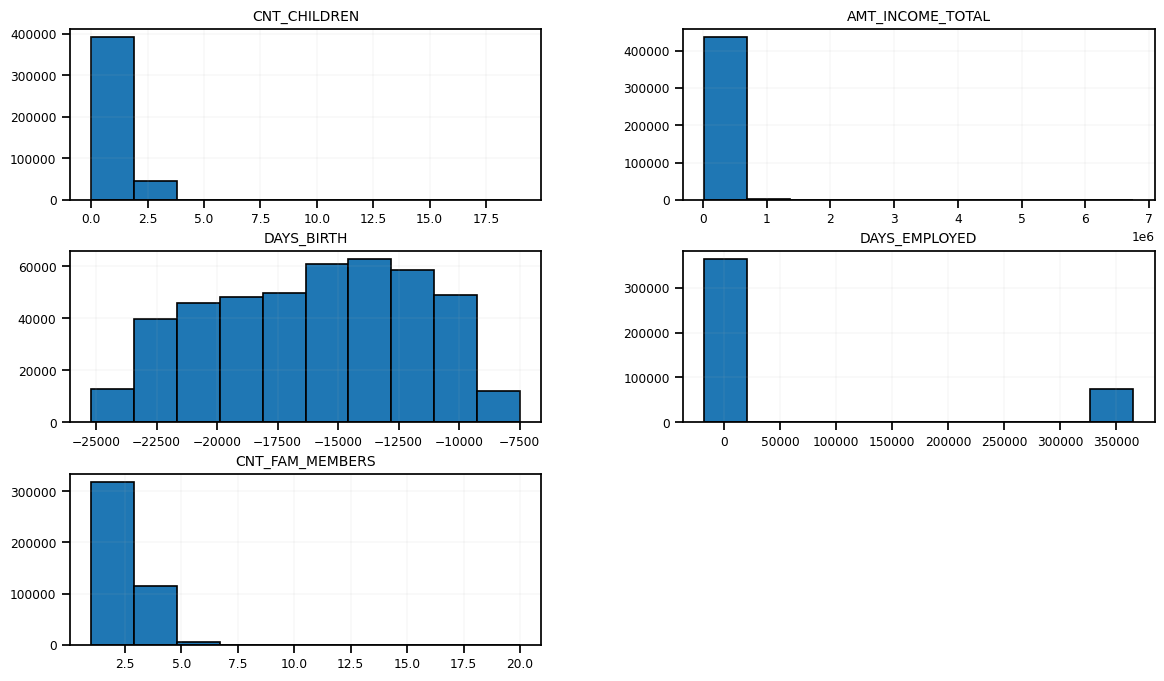

In [306]:
fig = plt.figure(figsize=(10,10))
data[["CNT_CHILDREN","AMT_INCOME_TOTAL","DAYS_BIRTH","DAYS_EMPLOYED",
      "CNT_FAM_MEMBERS"]].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(14,8)

CNT_CHILDREN and AMT_INCOME_TOTAL,CNT_FAM_MEMBERS has outlier

The last bar in DAYS_EMPLOYED graph represnts the customer is currently unemployed. (From the definition of dataset)

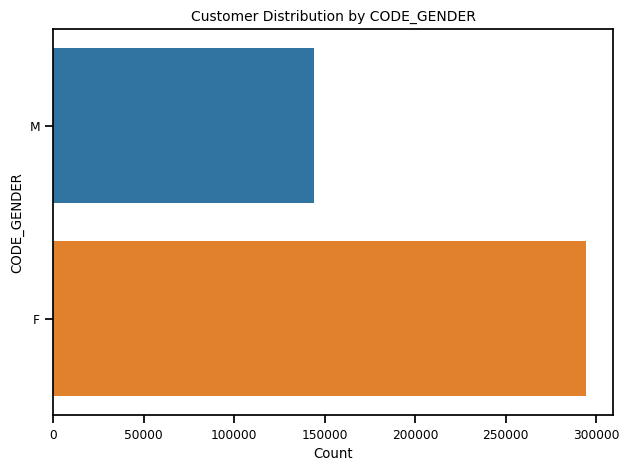

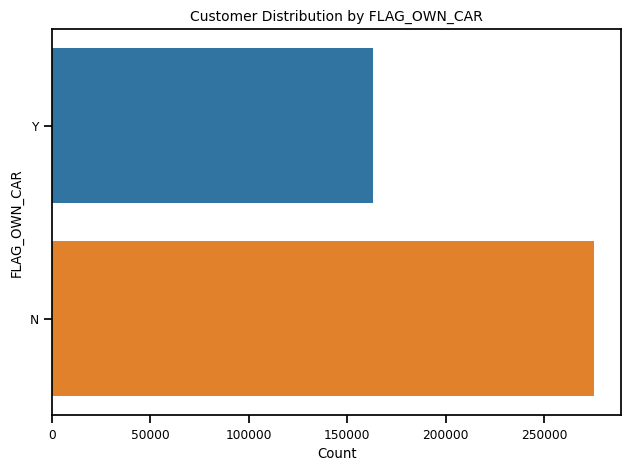

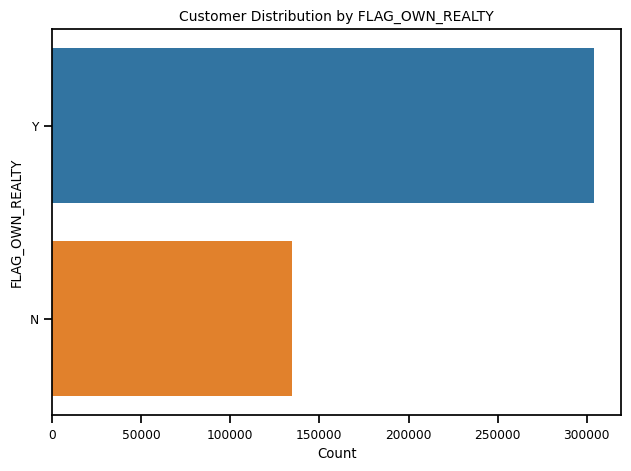

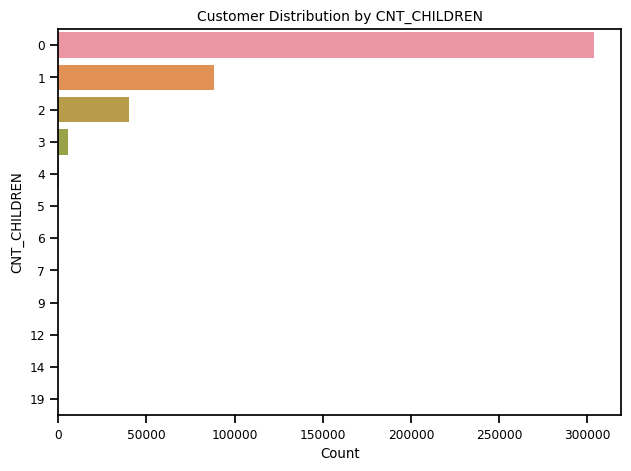

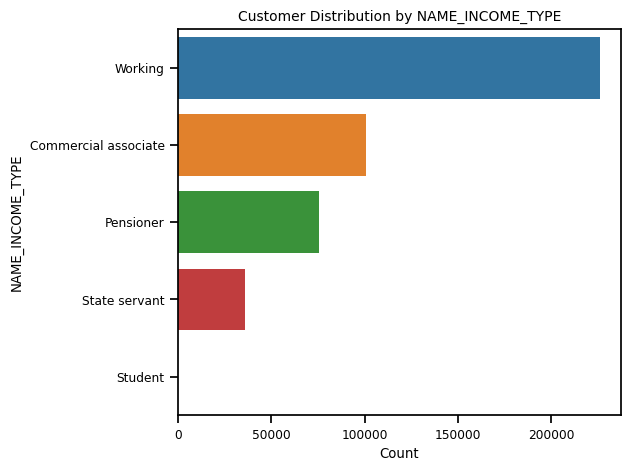

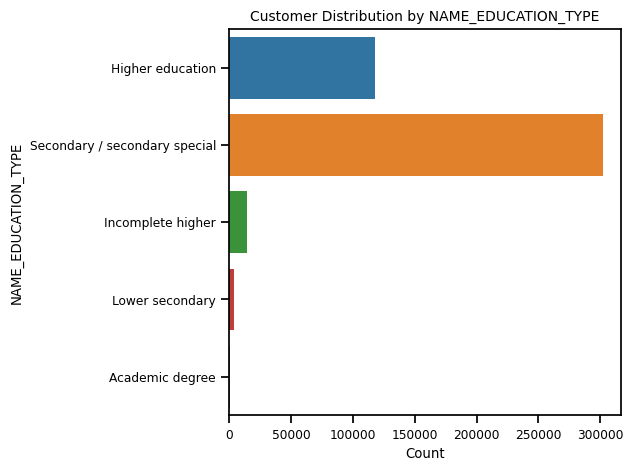

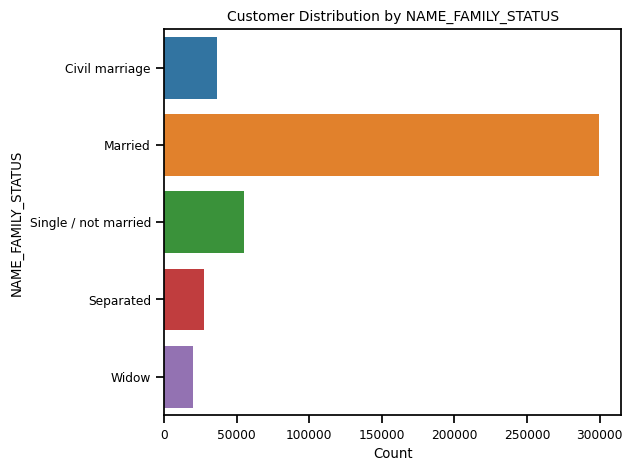

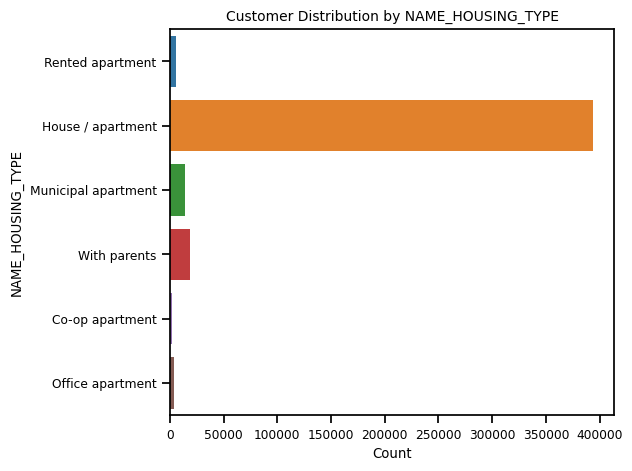

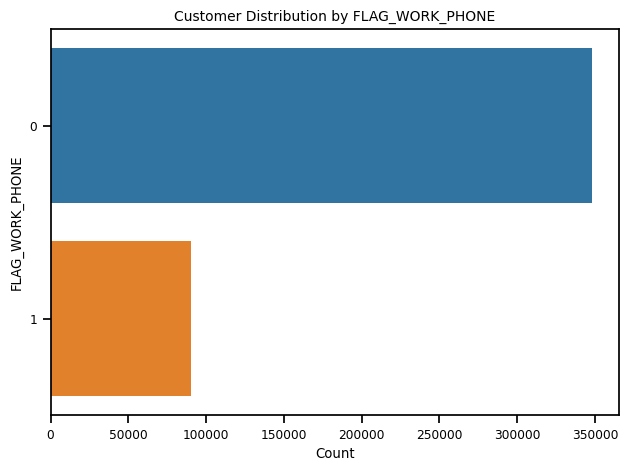

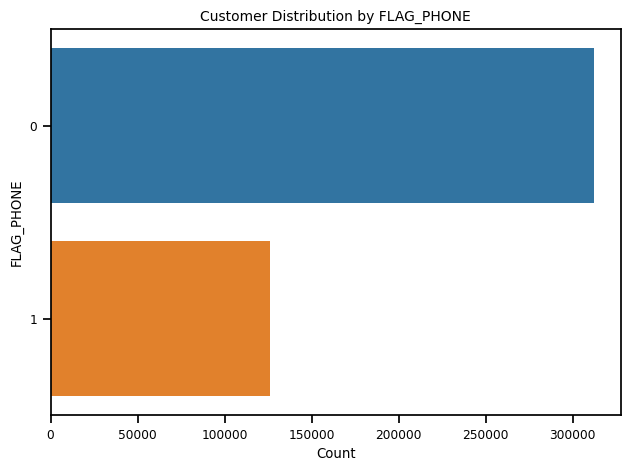

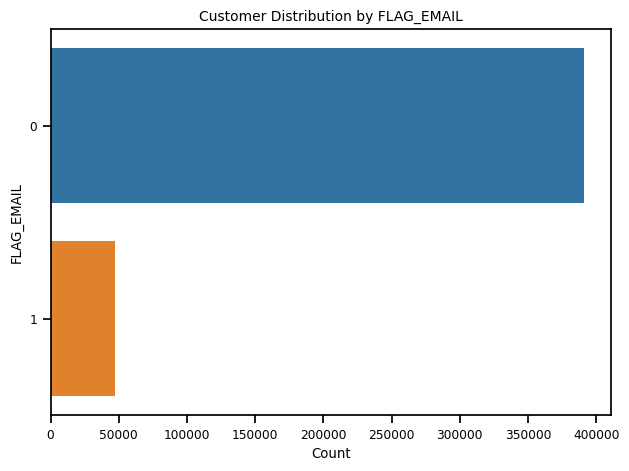

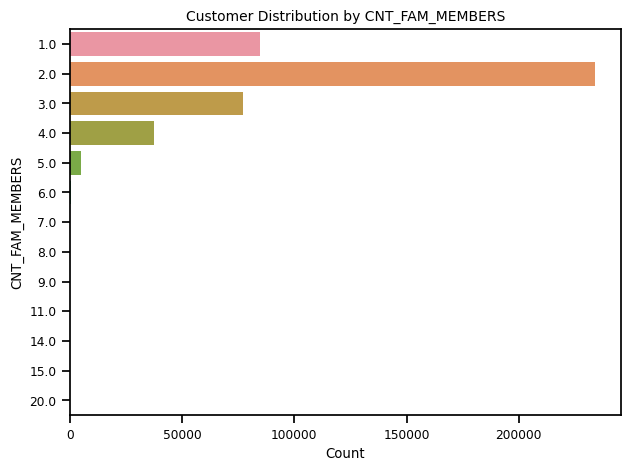

In [307]:
for col in data.columns:
    if (data[col].nunique()>1) & (data[col].nunique()<14):
        g=sns.countplot(y=data[col],linewidth=1.2)
        g.set_title("Customer Distribution by "+col)
        g.set_xlabel("Count")
        g.set_ylabel(col)
        fig.set_size_inches(14,5)
        plt.tight_layout()
        plt.show()

Majority of customer stays in their owned house/apartment.

Majority of customers are married

Education wise majority of customers are secondary exam passed

Source of Income for majority customers they are working.

Quite an interesting observation with respect to current situtation that majority of customers dont have Office Phone, Personal Phone or Email

In the contrary majority of customers own a property but they dont have cars. I can infer from this majority of customers are sensible towards building wealth rather than going for luxury products like car. (though now a days car is almost essential). But I feel majority of customers prefer public transport.

It is also fascinating to see majority of customers are Female.

It is obivious I need to transform some of the features to have meaningul impact.

In [308]:
#For credit records I will get start month for each loan
tmp=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min)).rename(columns=
                                                                                   {'MONTHS_BALANCE':'begin_month'}) 
#removing duplicate ID
data = data.drop_duplicates('ID', keep='last')
df=data.merge(tmp,on='ID',how='left')
df.shape,data.shape,record.shape

((438510, 19), (438510, 18), (1048575, 3))

In [309]:
#Removing OCCUPATION_TYPE and FLAG_MOBILE columns
#We can explore OCCUPATION_TYPE column little deeper rather than dropping to see if we can impute
#but since there is a time limitation for the submission. Hence I am dropping it.
df.drop(columns=['OCCUPATION_TYPE','FLAG_MOBIL'],inplace=True)
df.shape

(438510, 17)

In [310]:
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'begin_month'],
      dtype='object')

In [311]:
#Now based on above graphs on categorical features, I will transform those feature into more meaningful one.

family_status = {'Single / not married':'Unmarried',
                 'Separated':'Unmarried',
                 'Widow':'Unmarried',
                 'Civil marriage':'Married',
                 'Married':'Married'}
df["NAME_FAMILY_STATUS"] = df["NAME_FAMILY_STATUS"].map(family_status)

income_type = {'Working':True,
               'Commercial associate':True,
               'State servant':True,
               'Pensioner':False,
               'Student':False}
df["NAME_INCOME_TYPE"] = df["NAME_INCOME_TYPE"].map(income_type)

housing_type = {'With parents': 'With parents',
                'Municipal apartment' : 'House / apartment',
                'Rented apartment': 'House / apartment',
                'Office apartment': 'House / apartment',
                'Co-op apartment': 'House / apartment'}

df["NAME_HOUSING_TYPE"] = df['NAME_HOUSING_TYPE'].map(housing_type)

education_type = {'Secondary / secondary special':'secondary',
                  'Lower secondary':'secondary',
                  'Higher education':'Higher education',
                  'Incomplete higher':'Higher education',
                  'Academic degree':'Academic degree'}

df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].map(education_type)

In [312]:
#Handling CNT_CHILDREN and CNT_FAM_MEMBERS
df.loc[df['CNT_CHILDREN'] >= 2,'CNT_CHILDREN']='>=2'
df.loc[df['CNT_FAM_MEMBERS'] >= 3,'CNT_FAM_MEMBERS']='>=3'
df['CNT_CHILDREN']=df['CNT_CHILDREN'].astype('str')
df['CNT_FAM_MEMBERS']=df['CNT_FAM_MEMBERS'].astype('str')

In [313]:
df['Age']=-(df['DAYS_BIRTH'])//365
df['Experience']=-(df['DAYS_EMPLOYED'])//365
df.loc[df['Experience']<=0,'Experience']=0
df.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'],inplace=True)

In [314]:
#Now I will transform continuous features
tmp=df.drop(columns=['ID']).nunique().reset_index()
tmp.columns=['Feature','Unique_Count']
tmp.sort_values(by=['Unique_Count'])

,Feature,Unique_Count
0,CODE_GENDER,2
1,FLAG_OWN_CAR,2
2,FLAG_OWN_REALTY,2
5,NAME_INCOME_TYPE,2
7,NAME_FAMILY_STATUS,2
8,NAME_HOUSING_TYPE,2
9,FLAG_WORK_PHONE,2
10,FLAG_PHONE,2
11,FLAG_EMAIL,2
3,CNT_CHILDREN,3


In [315]:
num_columns=list(tmp.loc[tmp['Unique_Count'] >3,'Feature'].values)
num_columns

['AMT_INCOME_TOTAL', 'begin_month', 'Age', 'Experience']

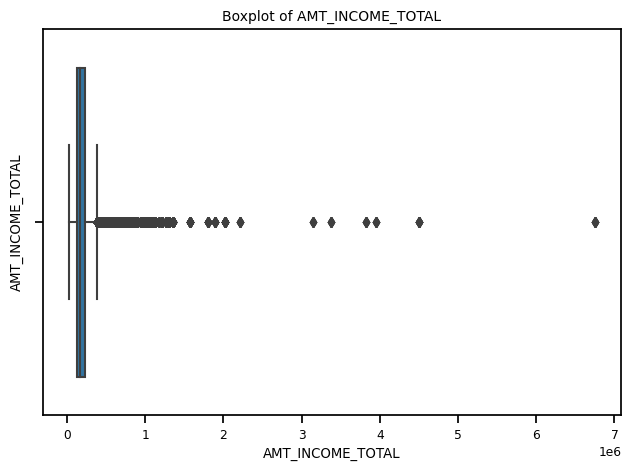

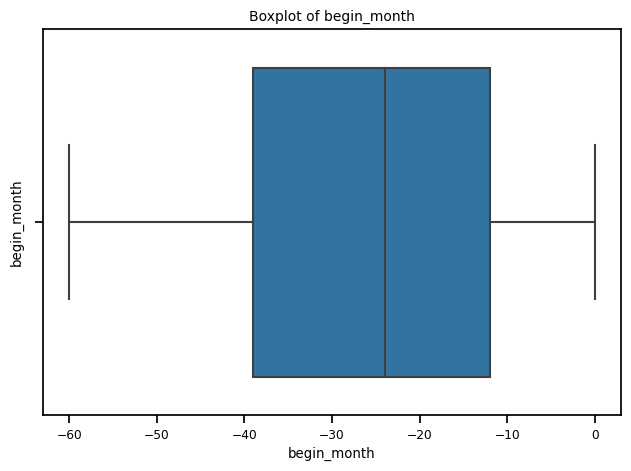

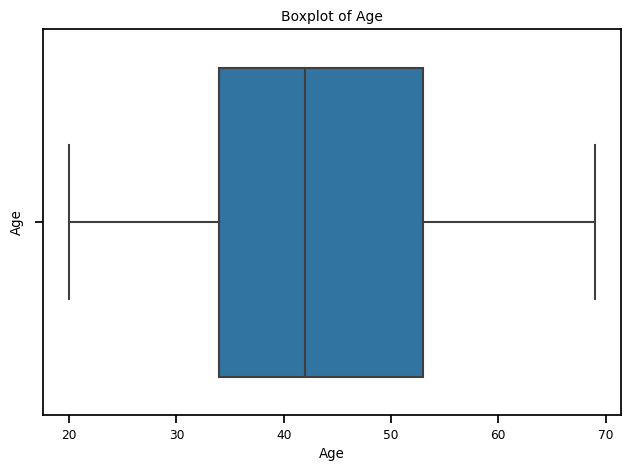

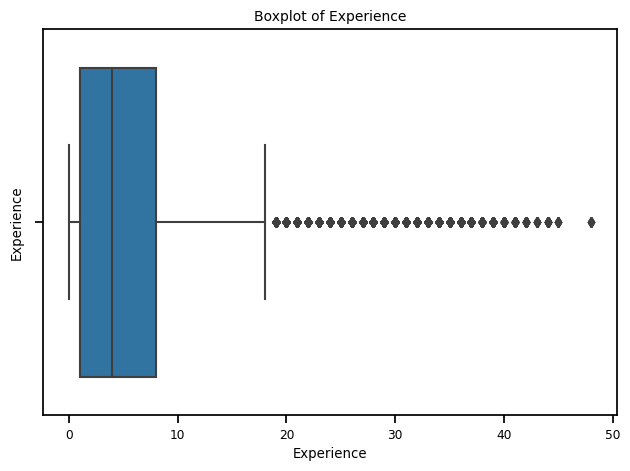

In [316]:
for col in num_columns:    
    g=sns.boxplot(x=df[col],orient='v')
    g.set_title("Boxplot of "+col)
    g.set_ylabel(col)
    fig.set_size_inches(14,5)
    plt.tight_layout()
    plt.show()

Experience and AMT_INCOME_TOTAL has outliers

People with experience close to 50 is something very strange. 

May be I will reason with age to see if there are customer where experience > age, I will drop those records

In [317]:
df['Age_Experience_diff']=df['Age'] - df['Experience']
df['Age_Experience_diff'].describe()

count    438510.000000
mean         37.790030
std          13.165499
min          17.000000
25%          27.000000
50%          35.000000
75%          47.000000
max          69.000000
Name: Age_Experience_diff, dtype: float64

This is quite normal, I can see min 17 years gap so that means there is a customer who got 1st job in 17 years of age.

I will keep this new feature and later point of time, I will take a call whether to keep this Age_Experience_diff alone
or will keep Age and Experience seperately

For AMT_INCOME_TOTAL problably last few are really outliers but rather than removing I will try create bucket of this feature

In [318]:
df.columns[df.dtypes =='object']

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'CNT_FAM_MEMBERS'],
      dtype='object')

In [319]:
#Now I will encode the columns which are of Object Data Type
le={}
for i in df.columns[df.dtypes =='object']:
  print (i)
  le[i]=LabelEncoder()
  df[i]=le[i].fit_transform(df[i])

CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
CNT_FAM_MEMBERS


In [320]:
le

{'CODE_GENDER': LabelEncoder(),
 'FLAG_OWN_CAR': LabelEncoder(),
 'FLAG_OWN_REALTY': LabelEncoder(),
 'CNT_CHILDREN': LabelEncoder(),
 'NAME_EDUCATION_TYPE': LabelEncoder(),
 'NAME_FAMILY_STATUS': LabelEncoder(),
 'NAME_HOUSING_TYPE': LabelEncoder(),
 'CNT_FAM_MEMBERS': LabelEncoder()}

In [321]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,begin_month,Age,Experience,Age_Experience_diff
0,5008804,1,1,1,0,427500.0,True,1,0,0,1,0,0,1,-15.0,32,12,20
1,5008805,1,1,1,0,427500.0,True,1,0,0,1,0,0,1,-14.0,32,12,20
2,5008806,1,1,1,0,112500.0,True,2,0,2,0,0,0,1,-29.0,58,3,55
3,5008808,0,0,1,0,270000.0,True,2,1,2,0,1,1,0,-4.0,52,8,44
4,5008809,0,0,1,0,270000.0,True,2,1,2,0,1,1,0,-26.0,52,8,44


In [322]:
#Calculate IV 
#Courtsey for IV calculate function: https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python/notebook
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """

    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

In [323]:
record['default']=np.where((record['STATUS'].isin(['2','3','4','5'])),1,0)
record_each_id=record.groupby('ID').sum()
record_each_id.loc[record_each_id['default'] > 0,'default']=1 
record_each_id = record_each_id[['default']]
record_each_id.head()

,default
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0


In [324]:
#Now I will analyze length of time since credit card is approved
# I will explore past dues, paid off and no loan.
tmp = record.groupby('ID')
pivot = record.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot['start_month'] = tmp['MONTHS_BALANCE'].min()
pivot['end_month'] = tmp['MONTHS_BALANCE'].max()
pivot['window'] = pivot['end_month'] - pivot['start_month']
pivot['window'] += 1 # Adding 1 as month start value is 0.

#Calculating past dues, paid offs and no loans count.
pivot['paid_off'] = pivot[pivot.iloc[:,0:61] == 'C'].count(axis = 1)
pivot['pastdue_1-29'] = pivot[pivot.iloc[:,0:61] == '0'].count(axis = 1)
pivot['pastdue_30-59'] = pivot[pivot.iloc[:,0:61] == '1'].count(axis = 1)
pivot['pastdue_60-89'] = pivot[pivot.iloc[:,0:61] == '2'].count(axis = 1)
pivot['pastdue_90-119'] = pivot[pivot.iloc[:,0:61] == '3'].count(axis = 1)
pivot['pastdue_120-149'] = pivot[pivot.iloc[:,0:61] == '4'].count(axis = 1)
pivot['pastdue_over_150'] = pivot[pivot.iloc[:,0:61] == '5'].count(axis = 1)
pivot['no_loan'] = pivot[pivot.iloc[:,0:61] == 'X'].count(axis = 1)
pivot['ID'] = pivot.index
pivot.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,window,paid_off,pastdue_1-29,pastdue_30-59,pastdue_60-89,pastdue_90-119,pastdue_120-149,pastdue_over_150,no_loan,ID
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,3,0,0,0,0,0,1,5001711
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19,9,10,0,0,0,0,0,0,5001712
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22,0,0,0,0,0,0,0,22,5001713
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0,0,0,0,0,0,0,15,5001714
5001715,NaN,X,X,X,X,X,X,X,X,X,...,60,0,0,0,0,0,0,0,60,5001715


In [325]:
final = pd.DataFrame()
final['ID'] = pivot.index
final['paid_off'] = pivot['paid_off'].values
final['pastdues_count'] = pivot['pastdue_1-29'].values+ pivot['pastdue_30-59'].values + pivot['pastdue_60-89'].values+pivot['pastdue_90-119'].values+pivot['pastdue_120-149'].values+pivot['pastdue_over_150'].values
final['no_loan'] = pivot['no_loan'].values
final1 = df.merge(final, on = 'ID')
final=pd.merge(final1,record_each_id,how='inner',on='ID')
final['target']=final['default']
final.drop(columns=["default"],inplace=True)

In [326]:
from tqdm import tqdm
iv_df=pd.DataFrame()
for col in tqdm(final.drop(columns=['ID']).columns):
    iv, tmp_df = calc_iv(final,col,'target')
    t1=pd.DataFrame([col,iv]).T
    iv_df=pd.concat([iv_df,t1])
iv_df.columns=['feature','iv']

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.31it/s]


In [327]:
iv_df.sort_values(by=['iv'],ascending=False)

,feature,iv
0,pastdues_count,1.186278
0,begin_month,0.332016
0,Age_Experience_diff,0.210195
0,Age,0.197881
0,AMT_INCOME_TOTAL,0.197373
0,paid_off,0.133346
0,no_loan,0.100319
0,Experience,0.08075
0,FLAG_OWN_REALTY,0.028349
0,NAME_FAMILY_STATUS,0.01645


<AxesSubplot:>

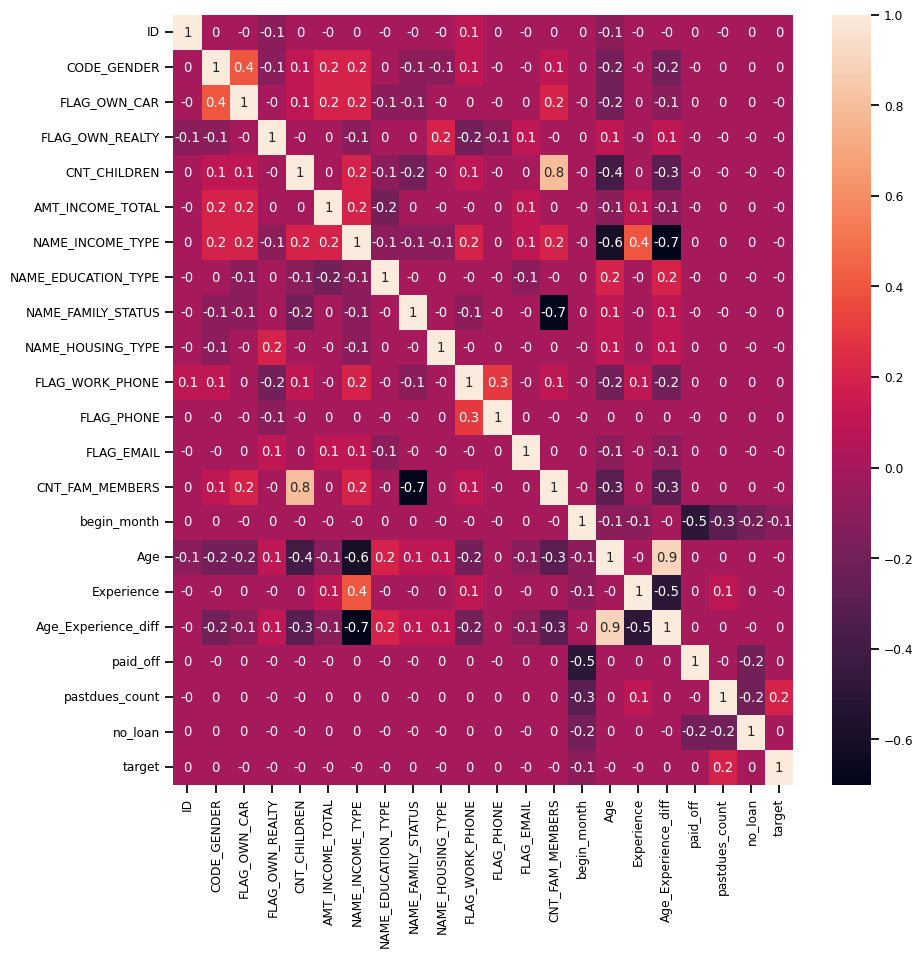

In [328]:
fig = plt.figure(figsize=(10,10))
corr = final.corr().round(1)
sns.heatmap(corr, annot=True)

Age_Experience_diff has more information value then Age and Experience. So I will remove both Age and Experience because they are correlated with Age_Experience_diff.

NAME_INCOME_TYPE has a strong correlation with Age_Experience_diff. I will drop NAME_INCOME_TYPE because it has quite a less information value.

In [329]:
final.drop(columns=['Age','Experience','NAME_INCOME_TYPE'],inplace=True)

At this point I have realized there could be a potential threat of data leakage since we can easily calculate target feature
from pastdues_count,paid_off,no_loan features. So I will remove them before model building

In [330]:
final.drop(columns=['pastdues_count','paid_off','no_loan'],inplace=True)

In [331]:
#training and test dataset creation
X = final.iloc[:,1:-1]
y = final[["target"]]

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((25519, 14), (10938, 14), (25519, 1), (10938, 1))

In [335]:
100*final['target'].value_counts(normalize=True)

0    98.310338
1     1.689662
Name: target, dtype: float64

Since the data is highly imbalanced, I will use SMOTE (Synthetic Minority Oversampling Technique) to resample the data.

In [336]:
#Taking a backup of Train before SMOTE resample
X_train_orig=X_train.copy()
y_train_orig=y_train.copy()

In [337]:
y_train = y_train.astype('int')
X_train,y_train = SMOTE().fit_resample(X_train,y_train)

In [338]:
#Dataset standardization
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [339]:
#Feature importance
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10)
clf.fit(X_train, y_train)
feature_importances = pd.DataFrame({"Feature":X_train_orig.columns,"Feature_Importance":clf.feature_importances_})
feature_importances=feature_importances.sort_values(by=['Feature_Importance'],ascending=False)
feature_importances

,Feature,Feature_Importance
12,begin_month,0.168933
4,AMT_INCOME_TOTAL,0.164468
13,Age_Experience_diff,0.146419
2,FLAG_OWN_REALTY,0.081506
11,CNT_FAM_MEMBERS,0.075171
1,FLAG_OWN_CAR,0.058314
5,NAME_EDUCATION_TYPE,0.049793
6,NAME_FAMILY_STATUS,0.045830
9,FLAG_PHONE,0.044523
8,FLAG_WORK_PHONE,0.040010


<AxesSubplot:>

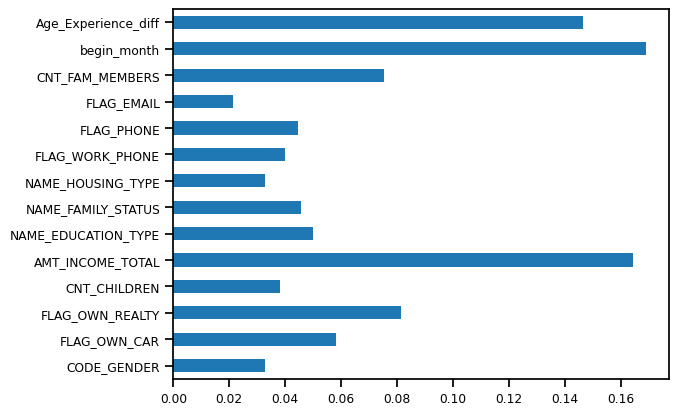

In [340]:
#feature_importances.plot(kind='barh')

(pd.Series(clf.feature_importances_, index=X.columns).plot(kind='barh')) 

In [341]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=250,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)
}

result_table = pd.DataFrame(columns=['classifiers','accuracy','presicion','recall','f1_score','fpr','tpr','auc'])
y_test = y_test.astype(int)


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    
    y_proba = classifier.predict_proba(X_test)[::,1]
 
    
    fpr, tpr, _ = roc_curve(y_test,  y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                         }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

0:	learn: 0.4926631	total: 1.62s	remaining: 6m 44s
25:	learn: 0.0981868	total: 41.7s	remaining: 5m 58s
50:	learn: 0.0611617	total: 1m 17s	remaining: 5m 2s
75:	learn: 0.0407353	total: 2m 3s	remaining: 4m 43s
100:	learn: 0.0279587	total: 2m 51s	remaining: 4m 12s
125:	learn: 0.0203784	total: 3m 37s	remaining: 3m 34s
150:	learn: 0.0159959	total: 4m 25s	remaining: 2m 54s
175:	learn: 0.0131059	total: 5m 13s	remaining: 2m 11s
200:	learn: 0.0111852	total: 6m 1s	remaining: 1m 28s
225:	learn: 0.0097807	total: 6m 47s	remaining: 43.3s
249:	learn: 0.0085928	total: 7m 36s	remaining: 0us


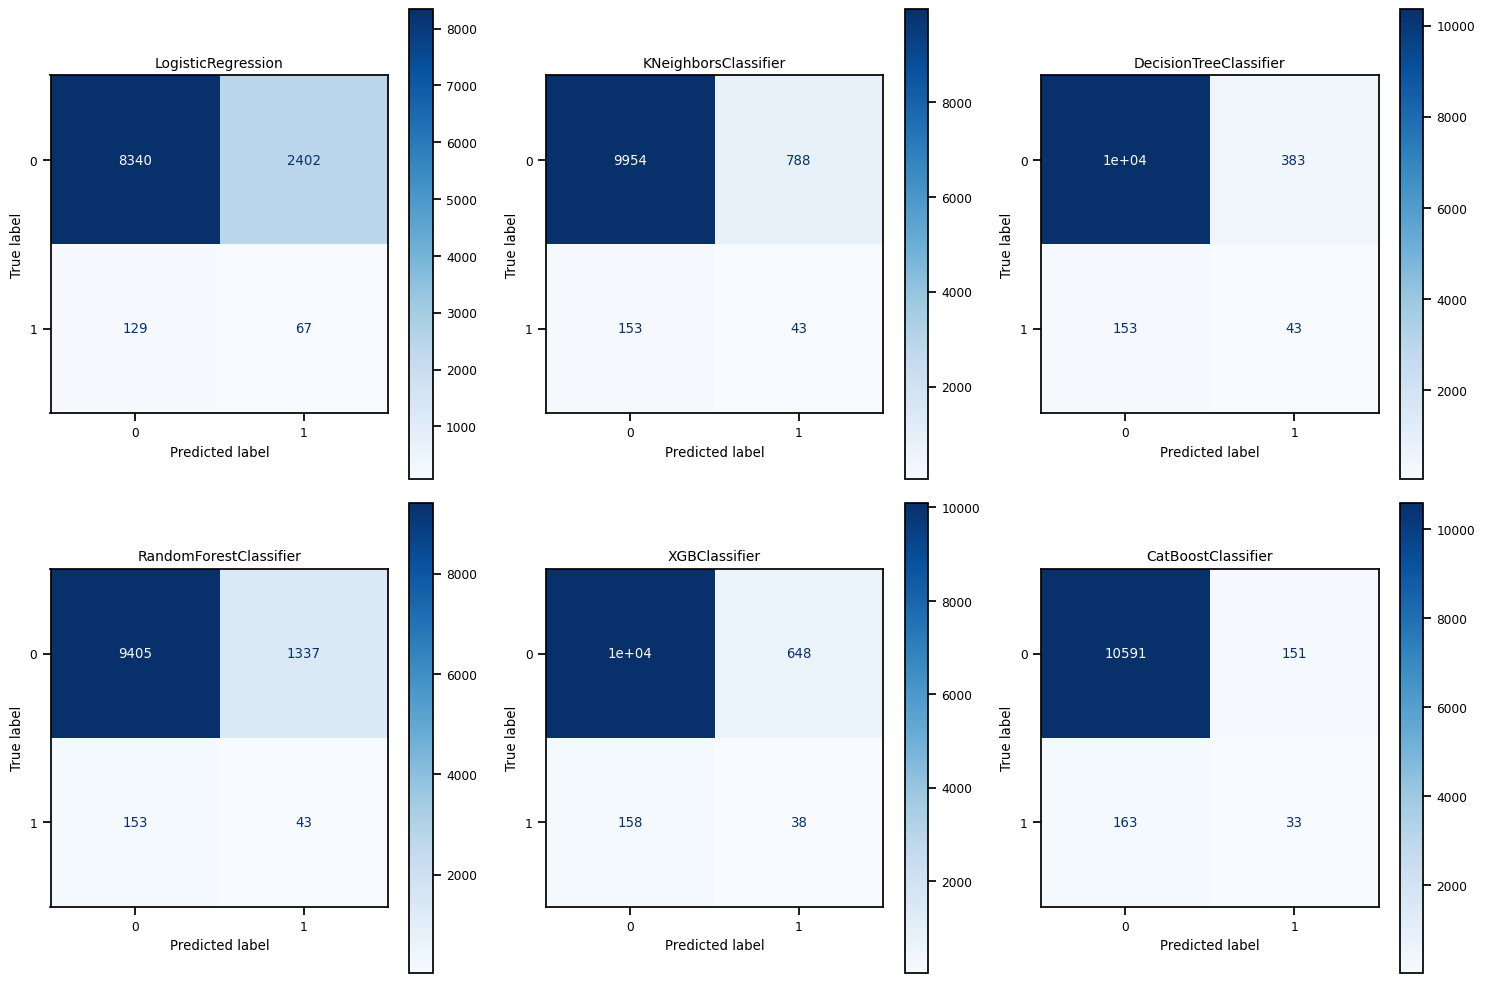

In [342]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

In [343]:
result_table

,accuracy,presicion,recall,f1_score,fpr,tpr,auc
classifiers,,,,,,,
LogisticRegression,0.768605,0.967608,0.768605,0.853595,"[0.0, 0.0, 0.0, 0.003165146155278347, 0.003165...","[0.0, 0.00510204081632653, 0.01530612244897959...",0.591438
KNeighbors,0.91397,0.968141,0.91397,0.939256,"[0.0, 0.020759635077266803, 0.0445913237758331...","[0.0, 0.1377551020408163, 0.1836734693877551, ...",0.629455
DecisionTree,0.950997,0.969596,0.950997,0.959792,"[0.0, 0.035561347979892015, 0.0356544405138707...","[0.0, 0.2193877551020408, 0.2193877551020408, ...",0.598637
RandomForest,0.863778,0.966918,0.863778,0.910975,"[0.0, 9.30925339787749e-05, 0.0001861850679575...","[0.0, 0.0, 0.00510204081632653, 0.005102040816...",0.660303
XGBoost,0.926312,0.967938,0.926312,0.945921,"[0.0, 0.0, 0.0, 0.0001861850679575498, 0.00018...","[0.0, 0.00510204081632653, 0.01020408163265306...",0.684581
CatBoost,0.971293,0.970409,0.971293,0.970847,"[0.0, 9.30925339787749e-05, 0.0001861850679575...","[0.0, 0.0, 0.0, 0.00510204081632653, 0.0051020...",0.719747


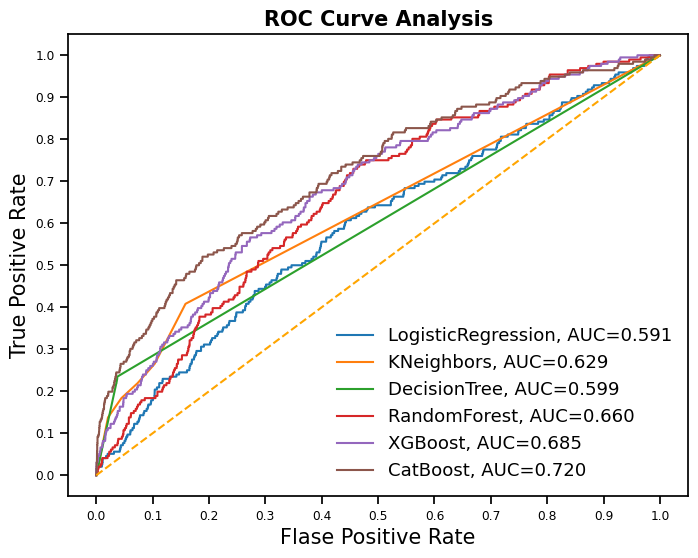

In [344]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [345]:
result_table[['accuracy', 'presicion', 'recall', 'f1_score', 'auc']]

,accuracy,presicion,recall,f1_score,auc
classifiers,,,,,
LogisticRegression,0.768605,0.967608,0.768605,0.853595,0.591438
KNeighbors,0.91397,0.968141,0.91397,0.939256,0.629455
DecisionTree,0.950997,0.969596,0.950997,0.959792,0.598637
RandomForest,0.863778,0.966918,0.863778,0.910975,0.660303
XGBoost,0.926312,0.967938,0.926312,0.945921,0.684581
CatBoost,0.971293,0.970409,0.971293,0.970847,0.719747
